In [37]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score

from control_systems.car_hillclimbing import HillClimbingCar
from pid_controller import PIDController
from anomaly_detection import CUSUMDetector

In [29]:
# CUSUM Tuning
cusum_thresholds = np.arange(2, 20, 0.5)
cusum_bs = np.arange(1, 13, 0.5)
best_f1 = float("-inf")
best_thres = 0
best_b = 0
for thres in cusum_thresholds:
    for cusum_b in cusum_bs:
        env = HillClimbingCar()

        run_tracker = env.run_control_system(   
                config={
                        "params": {
                            "m": 1200,       # Mass (kg)
                            "g": 9.81,       # Gravity (m/s^2)
                            "Cr": 0.01,      # Rolling resistance coefficient
                            "Cd": 0.3,       # Aerodynamic drag coefficient
                            "A": 2.2,        # Frontal area (m^2)
                            "rho": 1.225,    # Air density (kg/m^3)
                            "Fmax": 40000,    # Maximum engine force (N)
                        },
                        "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                        "dt": 0.1,
                        "time": 500,
                        "attack-start": 10,
                        "attack-end": 20,
                        "v-controller": PIDController(0.5, 0.5, 0.01),
                        "target-velocity": 20,
                        "process-noise-cov": np.diag([0.01, 0.1]),
                        "measurement-noise-cov": 0.2,
                        "anomaly-detector": CUSUMDetector(
                            thresholds=thres*np.array([0.16000361755278]),
                            b=np.array([0.18543593999687008]) + cusum_b*np.array([0.16000361755278])),
                    },
                show_plots=False
            )

        time = np.arange(0, 500, 0.1)
        attack_labels = [(x >= 10 and x <= 20) for x in time]
        attack_predictions = run_tracker.get_metrics(metric="attack_predictions")
        cm = confusion_matrix(attack_predictions, attack_predictions)
        prec = precision_score(attack_labels, attack_predictions)
        rec = recall_score(attack_labels, attack_predictions)
        acc = accuracy_score(attack_labels, attack_predictions)
        f1 = f1_score(attack_labels, attack_predictions)
        if f1 > best_f1:
            best_thres = thres
            best_b = cusum_b
            best_f1 = f1
            best_acc = acc
            best_rec = rec
            best_prec = prec
    print(f"-----------------\nParams: {best_thres, best_b}\nAccuracy: {best_acc}\nPrecision: {best_prec}\nRecall: {best_rec}")





/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/axel/miniconda3/envs/cats/lib/python3.12/site-packages/sklearn/metrics/_classification.py:

-----------------
Params: (10.5, 7.5)
Accuracy: 0.999
Precision: 0.9897959183673469
Recall: 0.9603960396039604


In [59]:
# MSE
mmsce2 = []
for mag in range(1, 10):
    msce = []
    for _ in range(100):
        env = HillClimbingCar()
        run_tracker = env.run_control_system(   
            config={
                    "params": {
                        "m": 1200,       # Mass (kg)
                        "g": 9.81,       # Gravity (m/s^2)
                        "Cr": 0.01,      # Rolling resistance coefficient
                        "Cd": 0.3,       # Aerodynamic drag coefficient
                        "A": 2.2,        # Frontal area (m^2)
                        "rho": 1.225,    # Air density (kg/m^3)
                        "Fmax": 40000,    # Maximum engine force (N)
                    },
                    "init-state": np.array([0, 20]),  # [Position (m), Velocity (m/s)]
                    "dt": 0.1,
                    "time": 50,
                    "attack-start": 10,
                    "attack-end": 20,
                    "attack-magnitude": mag,
                    "v-controller": PIDController(0.5, 0.5, 0.01),
                    "target-velocity": 20,
                    "process-noise-cov": np.diag([0.01, 0.1]),
                    "measurement-noise-cov": 0.2,
                    "anomaly-detector": CUSUMDetector(
                        thresholds=10.5*np.array([0.16000361755278]),
                        b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
                },
            show_plots=False
        )
        msce.append(np.mean(run_tracker.ms_control_error()))
    mmsce2.append(msce)


In [55]:
np.mean(msce), np.std(msce)

(6.945416828981613, 1.5582852595428953)

In [60]:
mmsce

[[1.2394993530961018,
  0.716866138378243,
  1.1581001396330879,
  1.1389033716844101,
  1.0945523267092965,
  1.7091209689987186,
  0.706034109934616,
  3.4828932197553297,
  0.7344541354703757,
  6.311446339175192,
  2.54567317878616,
  1.0535296626612074,
  1.8066019725535976,
  1.3755983297873395,
  1.1057262937590928,
  2.881783302155693,
  1.4976330250388534,
  0.7558491138881993,
  6.060332259576027,
  3.997509315922697,
  5.962353706069826,
  0.7004465416496831,
  0.8282993775018788,
  0.9483777670833048,
  1.1497341932706537,
  6.541297413143342,
  1.6139683762919166,
  5.137223028486922,
  2.218280187335575,
  2.409805344608582,
  3.938866757738063,
  6.369770293690431,
  1.1764569069653537,
  1.5695516908387863,
  1.438501917056007,
  7.624018800746597,
  14.960414406451992,
  1.8759742672216437,
  1.0286292609757757,
  2.4498358705841037,
  1.6742153115835692,
  3.2977135958103525,
  0.7715838604345964,
  1.590671280377795,
  3.4219876318813736,
  2.130609104344831,
  2.475

In [61]:
mmsce2

[[1.5251730983538587,
  2.1582316307355347,
  5.007142021239392,
  3.6561127155290154,
  2.9172005080130834,
  0.8416749831022722,
  1.9383284038341022,
  6.42452664311261,
  1.223095026554377,
  3.1573774291053285,
  2.341583516456729,
  1.657607064800578,
  2.1488891994528045,
  7.218700789020254,
  0.8782201954205016,
  1.3205303742761794,
  0.6992833752095161,
  1.9745663972816805,
  1.4835476709766857,
  0.9132654789292409,
  2.618703745312464,
  10.894040518286682,
  0.5299272252342319,
  1.6613053160726925,
  6.760011163264392,
  2.4490572980596834,
  0.6675312552638144,
  6.3960449922808005,
  0.9079793649425546,
  1.0675875281791793,
  1.4202443638319577,
  5.54011070800346,
  1.2827251306533975,
  4.480590951983375,
  17.269447112547283,
  11.235723799333984,
  1.8590750002474126,
  17.17600049209218,
  1.09416955712739,
  29.744775263561344,
  1.2016916867263923,
  8.015605455655335,
  4.235536469712787,
  0.8669386727329991,
  3.254980349305943,
  2.908568947025157,
  7.768

In [62]:
stats_base = [(np.mean(x), np.std(x)) for x in mmsce]
stats_ekf = [(np.mean(x), np.std(x)) for x in mmsce2]

In [63]:
stats_base

[(2.832507781423014, 2.731966852696139),
 (2.906980539729489, 2.3189911477739122),
 (3.974419222679005, 2.8821740646782383),
 (5.537558540264455, 2.6694691515266897),
 (6.988408049771854, 2.927412225644281),
 (9.073915296944083, 1.6407056926518482),
 (12.315243616441679, 2.469814534505944),
 (15.5058404754815, 2.0476267257742724),
 (20.36054567598587, 2.653298301283018)]

In [64]:
stats_ekf

[(4.291068675995974, 4.583600381541723),
 (5.493661806515961, 7.155542485222117),
 (4.293363980709232, 5.160414171290278),
 (4.44336095821563, 4.470654243522835),
 (5.201131238377831, 5.4657732726985655),
 (5.792390113324972, 7.833562170562348),
 (5.529581769538132, 3.9235456914677393),
 (6.270337314794597, 3.901243670583415),
 (7.22152837068931, 4.075659918571724)]

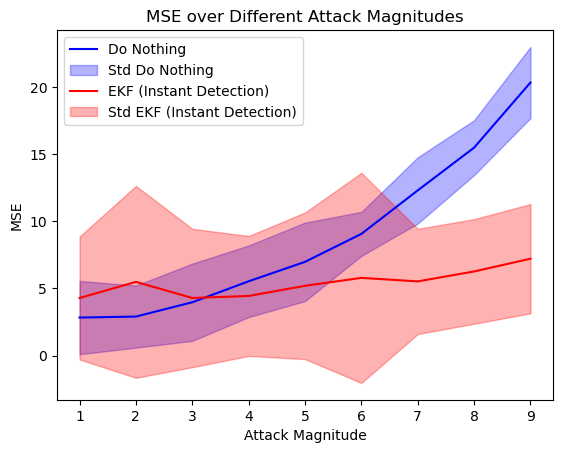

In [68]:
plt.plot(range(1, 10), [x[0] for x in stats_base], color="blue", label="Do Nothing")
plt.fill_between(range(1, 10), [-x[1]+x[0] for x in stats_base], [x[1] + x[0] for x in stats_base], color="blue", alpha=0.3, label="Std Do Nothing")
plt.plot(range(1, 10), [x[0] for x in stats_ekf], color="red", label="EKF (Instant Detection)")
plt.fill_between(range(1, 10), [-x[1] + x[0] for x in stats_ekf], [x[1] + x[0] for x in stats_ekf], color="red", alpha=0.3, label="Std EKF (Instant Detection)")
plt.title("MSE over Different Attack Magnitudes")
plt.xlabel("Attack Magnitude")
plt.ylabel("MSE")
plt.legend()
plt.show()

### PID-Tuning CarHillclimber

In [79]:


def pid_loss_fn(theta):
    Kp, Ki, Kd = theta
    env = HillClimbingCar()
    init_speed = 30*np.random.rand()

    tracker = env.run_control_system(
        config={
            "params": {
                "m": 1200,       # Mass (kg)
                "g": 9.81,       # Gravity (m/s^2)
                "Cr": 0.01,      # Rolling resistance coefficient
                "Cd": 0.3,       # Aerodynamic drag coefficient
                "A": 2.2,        # Frontal area (m^2)
                "rho": 1.225,    # Air density (kg/m^3)
                "Fmax": 40000,    # Maximum engine force (N)
            },
            "init-state": np.array([0, init_speed]),  # [Position (m), Velocity (m/s)]
            "dt": 0.1,
            "time": 50,
            "attack-start": -10,
            "attack-end": -20,
            "attack-magnitude": 0.0,
            "v-controller": PIDController(Kp, Ki, Kd),
            "target-velocity": 20,
            "process-noise-cov": np.diag([0.01, 0.1]),
            "measurement-noise-cov": 0.2,
            "anomaly-detector": CUSUMDetector(
                thresholds=10.5*np.array([0.16000361755278]),
                b=np.array([0.18543593999687008]) + 7.5*np.array([0.16000361755278])),
        },
        show_plots=False
    )

    loss = 0.1*tracker.ms_control_error().sum() / 50
    return loss

def compute_gradient(theta, delta):

    loss = pid_loss_fn(theta + delta*np.array([1,0,0]))
    dKp = (loss - pid_loss_fn(theta-delta*np.array([1,0,0]))) / (2*delta)
    dKi = (pid_loss_fn(theta + delta*np.array([0,1,0])) - pid_loss_fn(theta-delta*np.array([0,1,0]))) / (2*delta)
    dKd = (pid_loss_fn(theta + delta*np.array([0,0,1])) - pid_loss_fn(theta-delta*np.array([0,0,1]))) / (2*delta)

    return np.array([dKp, dKi, dKd]), loss


Loss at Step 0: 3.0037719533577474
Loss at Step 10: 2.927474337379327
Loss at Step 20: 2.9633476495605144
Loss at Step 30: 7.155367970599867
Loss at Step 40: 1.7771367539715197
Loss at Step 50: 2.3698208923820676
Loss at Step 60: 2.938858163643798
Loss at Step 70: 3.3950813005328566
Loss at Step 80: 6.849204407188466
Loss at Step 90: 4.208755873660497
Loss at Step 100: 7.243096497025303
Loss at Step 110: 3.7786366038266
Loss at Step 120: 2.3007914752876535
Loss at Step 130: 3.525039961031973
Loss at Step 140: 5.748587354761313
Loss at Step 150: 2.012506227575544
Loss at Step 160: 0.9018418275447868
Loss at Step 170: 2.224566112711632
Loss at Step 180: 4.2188847354054335
Loss at Step 190: 2.4068731557488063
Loss at Step 200: 4.654363358683967
Loss at Step 210: 3.714806677437826
Loss at Step 220: 3.0573926532193045
Loss at Step 230: 2.546007089875316
Loss at Step 240: 1.7589758372088602
Loss at Step 250: 14.891062618170876
Loss at Step 260: 1.9286967517379288
Loss at Step 270: 1.92640728

Text(0.5, 1.0, 'PID Controller Loss Function')

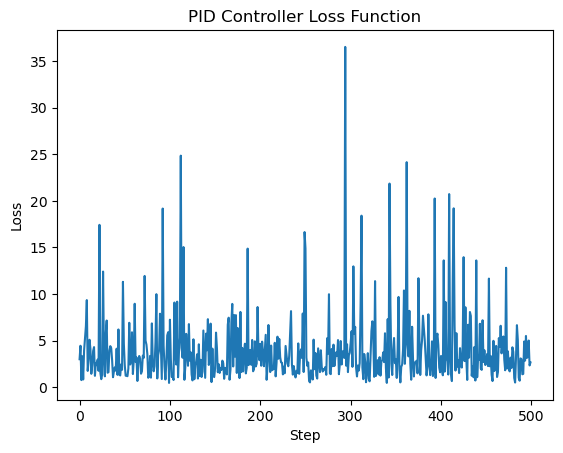

In [80]:
delta = 1e-5
theta0 = np.array([0.5, 0.5, 0.01])
lr = 1e-4
NBR_STEPS = 500


losses = []
theta = theta0
best_theta = theta0
best_loss = float("inf")
for step in range(NBR_STEPS):
    # Compute Gradient
    grad, loss = compute_gradient(theta, delta)
    grad = (1 / np.linalg.norm(grad, 2)) * grad
    
    # Gradient Descent
    theta = theta - lr*grad
    losses.append(loss)
    if loss < best_loss:
        best_theta = theta
    if step % 10 == 0:
        print(f"Loss at Step {step}: {loss}")

plt.plot(range(NBR_STEPS), losses)
plt.ylabel("Loss")
plt.xlabel("Step")
plt.title("PID Controller Loss Function")


In [81]:
best_theta

array([0.50320036, 0.50027134, 0.00711447])

### Data Analysis

In [10]:
import pandas as pd
df = pd.read_csv("./data/car_data_2025-01-2813:58:52.995259.csv")
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [11]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
0,0.00,0.000000,0.000000,0.000000,0.000000,0.511855,1.0,False,False
1,0.01,-0.006290,0.337350,-0.000020,0.422104,2.859814,1.0,False,True
2,0.02,0.023397,0.687754,0.003933,1.807135,2.121815,1.0,False,False
3,0.03,0.072534,1.044000,0.022011,2.130645,2.601476,1.0,False,False
4,0.04,0.073652,1.335810,0.043260,2.532229,2.097483,1.0,False,False


In [12]:
df[df.attack]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
1001,10.01,186.807971,18.921155,197.745466,19.350815,22.448632,-1.000000,True,False
1002,10.02,187.030770,18.541056,197.929340,20.707614,22.466158,-1.000000,True,False
1003,10.03,187.267246,18.226715,198.271672,21.410093,21.694554,-1.000000,True,True
1004,10.04,187.433597,17.820901,198.485773,21.025522,21.044277,-1.000000,True,True
1005,10.05,187.655739,17.464268,198.696028,20.641000,21.834518,-1.000000,True,True
...,...,...,...,...,...,...,...,...,...
1995,19.95,331.123824,15.068459,403.076567,21.051606,19.548916,0.067596,True,True
1996,19.96,331.302728,15.066907,403.287083,21.071664,18.923659,-0.032671,True,True
1997,19.97,331.504025,15.048521,383.518499,19.018183,21.057195,0.034390,True,False
1998,19.98,331.658659,15.074418,403.708454,21.062240,19.278741,0.007461,True,True


AttributeError: QuadMesh.set() got an unexpected keyword argument 'xlabel'

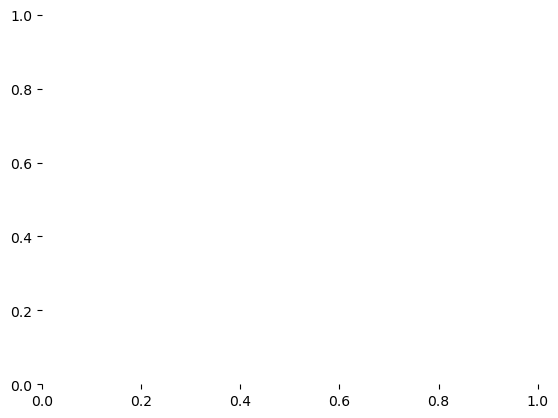

In [ ]:
FP = df[(df.attack == False) & (df.attack_pred == True)].count()
TP = df[(df.attack == True) & (df.attack_pred == True)].count()
FN = df[(df.attack == True) & (df.attack_pred == False)].count()
TN = df[(df.attack == False) & (df.attack_pred == False)].count()

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

cm = confusion_matrix(df.attack, df.attack_pred)
heatmap(data=cm, annot=True)
plt.xlabel("Predicted") 
plt.ylabel("Actual")

In [16]:
cm

array([[3035,  966],
       [  78,  921]])

In [8]:
df.loc[((df.vel < 18) | (df.vel > 23)) & (df.time > 5)]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
919,9.19,173.357822,17.735867,181.653302,20.172302,19.553952,1.000000,False,False
921,9.21,173.773742,17.800387,182.056567,20.106202,19.413242,1.000000,False,False
1047,10.47,197.970627,17.944479,207.510852,20.305364,18.253503,-0.347323,False,True
1048,10.48,198.147233,17.822148,207.813869,19.152234,19.399224,1.000000,False,False
1127,11.27,213.449347,17.987554,223.713673,20.201703,19.073604,0.014676,False,True
...,...,...,...,...,...,...,...,...,...
4958,49.58,946.228393,17.810710,991.678075,20.017587,17.540816,-0.071115,False,True
4959,49.59,946.410676,17.827948,992.007822,18.468690,19.571817,1.000000,False,False
4968,49.68,948.059552,17.786918,993.673122,20.219472,17.573940,-1.000000,False,True
4969,49.69,948.188626,17.481640,993.981386,18.731413,19.551335,1.000000,False,False


In [9]:
df[df.time > 5].describe()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal
count,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000
mean,27.500000,524.409691,19.071451,549.481996,20.073139,20.072784,0.011390
std,12.988938,248.608140,0.564591,260.540189,0.587711,1.168145,0.895398
min,5.010000,92.101035,17.375048,96.887033,17.058279,15.615745,-1.000000
25%,16.255000,310.175191,18.680016,324.329378,19.752410,19.298431,-1.000000
50%,27.500000,523.659221,19.085809,549.634657,20.081929,20.062103,0.028121
75%,38.745000,739.804540,19.470514,774.948028,20.409340,20.868049,1.000000
max,49.990000,953.840770,20.744593,999.985079,22.883325,24.858485,1.000000


In [36]:
df.iloc[90:140]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
90,9.0,180.840348,19.133372,179.586037,18.872830,18.127091,0.417485,False,False
91,9.1,182.950038,20.603202,183.210170,19.728531,22.262444,0.057378,False,True
92,9.2,184.857321,20.740471,183.389533,20.808217,21.663837,-0.362960,False,False
93,9.3,186.930823,19.652015,185.463465,20.618941,21.680878,-0.399986,False,False
94,9.4,188.798337,18.280493,187.517510,20.471251,19.327036,0.084242,False,False
95,9.5,190.637591,18.428134,189.569526,20.027549,18.742392,0.226323,False,False
96,9.6,192.591948,19.167571,191.579331,19.750464,21.007907,-0.246939,False,False
97,9.7,194.417875,18.216659,195.150159,19.927912,17.511314,0.020276,False,True
98,9.8,196.295065,18.349686,195.551684,18.755876,17.803005,0.489197,False,False
99,9.9,198.018195,19.766263,197.436059,19.083879,19.175902,0.231100,False,False


Text(0.5, 1.0, 'Velocity over Time')

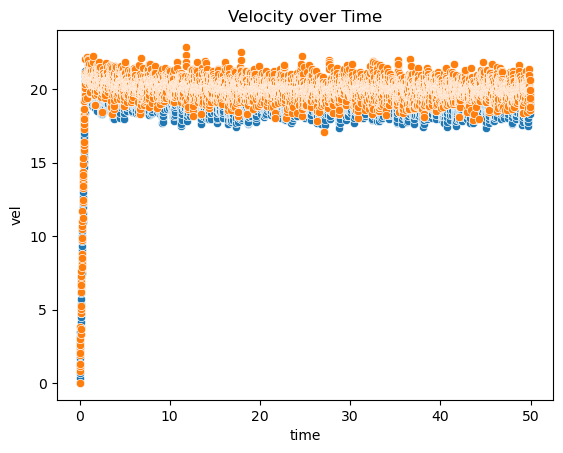

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df, x='time', y='vel')
sns.scatterplot(data=df, x='time', y='est_vel')
plt.title("Velocity over Time")

In [7]:
df.loc[~(df.attack) & (df.attack_pred) & (df.time > 5)]

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred
505,5.05,92.856915,19.827098,97.652120,20.255336,21.867987,0.822615,False,True
506,5.06,93.078556,20.109179,97.854674,20.527178,22.642834,-0.552444,False,True
512,5.12,94.394066,19.014484,99.071779,20.571764,18.928502,-0.791390,False,True
515,5.15,95.066961,19.340630,99.692413,20.060722,21.281079,1.000000,False,True
517,5.17,95.558123,19.369000,100.088980,20.736085,23.409860,-1.000000,False,True
...,...,...,...,...,...,...,...,...,...
4984,49.84,950.828823,19.779336,996.892809,19.897486,21.357622,0.524446,False,True
4988,49.88,951.605970,18.972035,997.691559,20.978152,19.098403,-1.000000,False,True
4989,49.89,951.825231,18.620984,997.901340,20.642355,17.598710,-1.000000,False,True
4992,49.92,952.449052,18.936541,998.522408,20.007886,18.004244,-0.028338,False,True


In [50]:
df['ref_vel'] = 20

In [54]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,ref_vel
0,0.0,0.000000,20.000000,0.000000,20.000000,21.167560,-0.256863,False,False,20
1,0.1,1.957502,19.044046,1.986816,20.144117,19.473102,0.092566,False,False,20
2,0.2,3.992475,19.487835,4.004517,19.951124,17.697133,0.043997,False,True,20
3,0.3,5.821805,19.740340,5.999630,20.074561,20.684827,0.004122,False,True,20
4,0.4,7.802057,19.779279,8.007086,20.064914,17.513692,0.054479,False,True,20


In [57]:
df['error'] = (df.vel-df.ref_vel).apply(lambda x: x**2)

In [58]:
df.head()

,time,pos,vel,est_pos,est_vel,measured_vel,ctl_signal,attack,attack_pred,ref_vel,error
0,0.0,0.000000,20.000000,0.000000,20.000000,21.167560,-0.256863,False,False,20,0.000000
1,0.1,1.957502,19.044046,1.986816,20.144117,19.473102,0.092566,False,False,20,0.913847
2,0.2,3.992475,19.487835,4.004517,19.951124,17.697133,0.043997,False,True,20,0.262313
3,0.3,5.821805,19.740340,5.999630,20.074561,20.684827,0.004122,False,True,20,0.067423
4,0.4,7.802057,19.779279,8.007086,20.064914,17.513692,0.054479,False,True,20,0.048718


In [59]:
df.error.mean()

0.6276287959619701

In [66]:
df2 = pd.read_csv("./data/car_data_2025-01-27 15:25:40.567818.csv")
df2['ref_vel'] = 20
df2['error'] = (df2.vel-df2.ref_vel).apply(lambda x: x**2)
df2.error.mean()

1.302346612012994